聚类与分类的最大不同在于，分类的目标事先已知，而聚类则不一样，类别没有预先定义，因此聚类有时也被称作无监督分类（unsupervised classification）。

聚类分析试图将相似对象归为同一簇，相似这一概念取决于选择的相似度计算方法。

## 1、K-均值聚类算法

> 优点：容易实现

> 缺点：可能收敛到局部的最小值，在大规模数据集上收敛较慢

> 适用数据类型：数值型数据

In [1]:
import numpy as np

In [2]:
def loadDataSet(fileName):
    dataMat = []
    with open(fileName) as f:
        for line in f:
            curLine = line.strip().split('\t')
            fltLine = list(map(float, curLine))
            dataMat.append(fltLine)
    return np.mat(dataMat)

In [3]:
def distEclud(vecA, vecB):
    return np.sqrt(np.sum(np.power(vecA-vecB, 2)))

In [4]:
def randCent(dataSet, k):
    m, n = dataSet.shape
    centroids = np.mat(np.zeros((k, n)))
    for j in range(n):
        minJ = min(dataSet[:, j])
        rangeJ = float(max(dataSet[:, j]) - minJ)
        centroids[:, j] = minJ + rangeJ * np.random.rand(k, 1)
    return centroids

In [7]:
dataMat = loadDataSet('testSet.txt')
min(dataMat[:, 0])

matrix([[-5.379713]])

In [9]:
randCent(dataMat, 2)

matrix([[ 4.58058346,  1.30334366],
        [-2.05728661,  0.99675092]])

In [81]:
def kMeans(dataSet, k, distMeans=distEclud, createCnt=randCent):
    m, n = dataSet.shape
    clusterAssment = np.mat(np.zeros((m, 2)))
    centroids = createCnt(dataSet, k)
    clusterChanged = True
    while clusterChanged:
        clusterChanged = False
        for i in range(m):
            minDist = np.inf
            minIndex = -1
            for j in range(k):
                distJI = distMeans(centroids[j, :], dataSet[i, :])
                if distJI < minDist:
                    minDist = distJI
                    minIndex = j
            if clusterAssment[i, 0] != minIndex:
                clusterChanged = True
            clusterAssment[i, :] = minIndex, minDist**2
        #print(centroids)
        # 更新质心位置
        for cent in range(k):
            ptsInClust = dataSet[np.nonzero(clusterAssment[:, 0].A == cent)[0]]
            centroids[cent, :] = np.mean(ptsInClust, axis=0)
    return centroids, clusterAssment

In [28]:
myCentroids, clustAssing = kMeans(dataMat, 4)

[[-3.81677415  3.13212213]
 [ 3.73038617 -2.89489171]
 [-0.88482855 -3.57668476]
 [ 3.08590219 -2.81467095]]
[[-1.28835556  3.12730756]
 [ 4.32207086 -0.87673529]
 [-3.01169468 -3.01238673]
 [ 2.60413875 -0.32014804]]
[[-1.28835556  3.12730756]
 [ 3.62349038 -2.539887  ]
 [-3.19984738 -2.96423548]
 [ 2.45199805  0.79864568]]
[[-1.94392522  2.96291883]
 [ 2.91339042 -2.85004268]
 [-3.38237045 -2.9473363 ]
 [ 2.70634522  2.73858333]]
[[-2.46154315  2.78737555]
 [ 2.80293085 -2.7315146 ]
 [-3.38237045 -2.9473363 ]
 [ 2.6265299   3.10868015]]


## 2、使用后处理来提高聚类性能

k-均值聚类中簇的数目是预先定义的，不同的k的选择，对于聚类的结果是有影响的。一种用于度量聚类效果的指标是SSE（sum of squared error， 误差平方和）。SSE的值越小，说明越接近质心。

聚类的目标实在保持簇数目不变的情况下提高簇的质量。

## 3、二分K-均值算法

为克服K-均值算法收敛于局部最小值的问题，有人提出一个称为二分k-均值的算法，该算法首先将所有点作为一个簇，然后将该簇一分为二，之后选择其中一个簇进行划分，选择的簇取决于对其划分是否可以最大程度降低SSE的值。

In [115]:
def bitKmeans(dataSet, k, distMeans=distEclud):
    m, n = dataSet.shape
    clusterAssment = np.mat(np.zeros((m, 2)))
    centroid0 = np.mean(dataSet, axis=0).tolist()[0]
    centList = [centroid0]
    for j in range(m):
        clusterAssment[j, 1] = distMeans(np.mat(centroid0), dataSet[j, :])**2
    while (len(centList) < k):
        loweseSSE = np.inf
        for i in range(len(centList)):
            ptsInCurrCluster = dataSet[np.nonzero(clusterAssment[:, 0].A == i)[0], :]
            centroidMat, splitClustAss = kMeans(ptsInCurrCluster, 2, distMeans)
            sseSplit = np.sum(splitClustAss[:, 1])
            sseNotSplit = np.sum(clusterAssment[np.nonzero(clusterAssment[:, 0].A != i)[0], 1])
            #print("sseSplit, and notSplit: ", sseSplit, sseNotSplit)
            if (sseSplit + sseNotSplit) < loweseSSE:
                bestCentToSplit = i
                bestNewCents = centroidMat
                bestClustAss = splitClustAss.copy()
                loweseSSE = sseSplit + sseNotSplit
        bestClustAss[np.nonzero(bestClustAss[:, 0].A == 1)[0], 0] = len(centList)
        bestClustAss[np.nonzero(bestClustAss[:, 0].A == 0)[0], 0] = bestCentToSplit
        #print('the bestCentToSplit is: ', bestCentToSplit)
        #print('the len of bestClustAss is: ', len(bestClustAss))
        centList[bestCentToSplit] = bestNewCents[0, :]
        centList.append(bestNewCents[1, :])
        clusterAssment[np.nonzero(clusterAssment[:, 0].A == bestCentToSplit)[0], :] = bestClustAss
    return centList, clusterAssment

In [23]:
dataMat3 = np.mat(loadDataSet('testSet2.txt'))
centList, myNewAssment = bitKmeans(dataMat3, 3)

[[-3.59677951  3.78728506]
 [ 0.81534924 -1.72169334]]
[[-2.37180191  3.3769933 ]
 [ 1.21859673 -0.11219024]]
[[-2.71560067  3.37937762]
 [ 1.21959613  0.06545838]]
[[-2.94737575  3.3263781 ]
 [ 1.23710375  0.17480612]]
sseSplit, and notSplit:  570.722757425 0.0
the bestCentToSplit is:  0
the len of bestClustAss is:  60
[[-3.29122009  1.62755697]
 [-4.6900375   3.39873204]]
[[-2.50619333  2.817112  ]
 [-3.60914937  4.09027725]]
[[-2.56458833  2.9616746 ]
 [-4.095738    4.4204886 ]]
sseSplit, and notSplit:  21.2908596794 532.659806789
[[ 2.5400151   1.62864431]
 [ 2.45313181 -1.62422533]]
[[ 2.93386365  3.12782785]
 [-0.45965615 -2.7782156 ]]
sseSplit, and notSplit:  68.6865481262 38.0629506357
the bestCentToSplit is:  1
the len of bestClustAss is:  40


In [24]:
centList

[matrix([[-2.94737575,  3.3263781 ]]),
 matrix([[ 2.93386365,  3.12782785]]),
 matrix([[-0.45965615, -2.7782156 ]])]

## 4、示例：对地图上的点进行聚类

### 4.1 google maps API

In [32]:
import urllib
import json

In [73]:
def geoGrab(stAddress, city):
    location = '+'.join(stAddress.split(' ')) + ',+' + city
    apiStem = 'https://maps.googleapis.com/maps/api/geocode/json?address={0}&key=YOUR_KEY'.format(location)
    #print(apiStem)
    c = urllib.request.urlopen(apiStem)
    return json.loads(c.read())

In [27]:
from time import sleep

In [68]:
def massPlaceFind(fileName):
    with open('places.txt', 'w') as f:
        for line in open(fileName).readlines():
            line = line.strip()
            lineArr = line.split(',')[0].split('\t')
            retDict = geoGrab(lineArr[1], lineArr[2])
            if retDict['status'] == 'OK':
                lat = float(retDict['results'][0]['geometry']['location']['lat'])
                lng = float(retDict['results'][0]['geometry']['location']['lng'])
                print('{0}\t{1}\t{2}\n'.format(line, lat, lng))
                f.write('{0}\t{1}\t{2}\n'.format(line, lat, lng))
            else:
                print('error fetching')
            sleep(1)
    print('success')

In [65]:
geoResults = geoGrab('10860 SW Beaverton-Hillsdale Hwy', 'Beaverton')
geoResults

{'results': [{'address_components': [{'long_name': '10860',
     'short_name': '10860',
     'types': ['street_number']},
    {'long_name': 'Southwest Beaverton Hillsdale Highway',
     'short_name': 'SW Beaverton Hillsdale Hwy',
     'types': ['route']},
    {'long_name': 'Raleigh West',
     'short_name': 'Raleigh West',
     'types': ['neighborhood', 'political']},
    {'long_name': 'Beaverton',
     'short_name': 'Beaverton',
     'types': ['locality', 'political']},
    {'long_name': 'Washington County',
     'short_name': 'Washington County',
     'types': ['administrative_area_level_2', 'political']},
    {'long_name': 'Oregon',
     'short_name': 'OR',
     'types': ['administrative_area_level_1', 'political']},
    {'long_name': 'United States',
     'short_name': 'US',
     'types': ['country', 'political']},
    {'long_name': '97005', 'short_name': '97005', 'types': ['postal_code']},
    {'long_name': '3004',
     'short_name': '3004',
     'types': ['postal_code_suffix']}],

In [69]:
massPlaceFind('portlandClubs.txt')

Dolphin II	10860 SW Beaverton-Hillsdale Hwy	Beaverton, OR	45.4860987	-122.7884026

Hotties	10140 SW Canyon Rd.	Beaverton, OR	45.49285219999999	-122.7810725

Pussycats	8666a SW Canyon Road	Beaverton, OR	45.4980156	-122.7666012

Stars Cabaret	4570 Lombard Ave	Beaverton, OR	45.48585440000001	-122.7998798

Sunset Strip	10205 SW Park Way	Beaverton, OR	45.5081228	-122.7801245

Vegas VIP Room	10018 SW Canyon Rd	Beaverton, OR	45.4931349	-122.7799455

Full Moon Bar and Grill	28014 Southeast Wally Road	Boring, OR	45.43020490000001	-122.3748312

505 Club	505 Burnside Rd	Gresham, OR	45.5107417	-122.4369895

Dolphin	17180 McLoughlin Blvd	Milwaukie, OR	45.39970350000001	-122.6182706

Dolphin III	13305 SE McLoughlin BLVD	Milwaukie, OR	45.42681899999999	-122.6349958

Acropolis	8325 McLoughlin Blvd	Portland, OR	45.4624691	-122.6392067

Blush	5145 SE McLoughlin Blvd	Portland, OR	45.4853106	-122.6470914

Boom Boom Room	8345 Barbur Blvd	Portland, OR	45.4644377	-122.7000494

Bottoms Up	16900 Saint Helens R

### 2、对地理坐标进行聚类

In [72]:
def distSLC(vecA, vecB):
    # 球面距离计算
    a = np.sin(vecA[0, 1] * np.pi/180) * np.sin(vecB[0, 1] * np.pi/180)
    b = np.cos(vecA[0, 1] * np.pi/180) * np.cos(vecB[0, 1] * np.pi/180) * \
        np.cos(np.pi * (vecB[0, 0] - vecA[0, 0]) / 180)
    return np.arccos(a + b) * 6371.0

In [71]:
import matplotlib
import matplotlib.pyplot as plt

In [142]:
def clustClubs(numClust=5):
    datList = []
    for line in open('places.txt').readlines():
        lineArr = line.split('\t')
        datList.append([float(lineArr[4]), float(lineArr[3])])
    datMat = np.mat(datList)
    myCentroids, clustAssing = bitKmeans(datMat, numClust, distSLC)

    fig = plt.figure()
    rect = [0.1, 0.1, 0.8, 0.8]
    scatterMarkers = ['s', 'o', '^', '8', 'p', 'd', 'v', 'h', '>', '<']
    axprops = dict(xticks=[], yticks=[])
    ax0 = fig.add_axes(rect, label='ax0', **axprops)
    imgP = plt.imread('Portland.png')
    ax0.imshow(imgP)
    ax1 = fig.add_axes(rect, label='ax1', frameon=False)
    for i in range(numClust):
        ptsInCurrCluster = datMat[np.nonzero(clustAssing[:, 0].A == i)[0], :]
        markerStyle = scatterMarkers[i % len(scatterMarkers)]
        ax1.scatter(ptsInCurrCluster[:, 0].flatten().A[0], \
                    ptsInCurrCluster[:, 1].flatten().A[0], \
                    marker=markerStyle, s=90)
    centroids = []
    for i in myCentroids:
        centroids.append(i.tolist()[0])
    centroids = np.array(centroids)
    ax1.scatter(centroids[:, 0],\
                centroids[:, 1], marker='+', s=300)
    plt.show()

E:\Anaconda3\lib\site-packages\numpy\matrixlib\defmatrix.py:549: RuntimeWarning: Mean of empty slice.
  return N.ndarray.mean(self, axis, dtype, out, keepdims=True)._collapse(axis)
E:\Anaconda3\lib\site-packages\numpy\core\_methods.py:73: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)


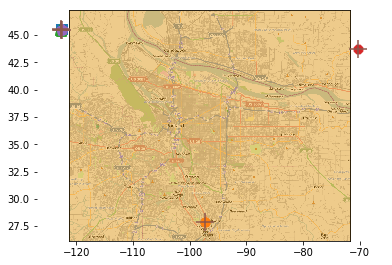

In [144]:
clustClubs(5)

不知道哪个地方出了问题......

> 总结：聚类是一种无监督的学习方法，k-均值算法是一种广泛使用的聚类算法，为了获得更好的聚类效果，可以使用一种称为二分k-均值的聚类算法。